<a href="https://colab.research.google.com/github/nisarahamedk/Kaggle_Notebooks/blob/master/melanoma_classification/01_combine_context_and_external_data_to_tfrec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Combine context + external data into TFRecords for TPU training.

#### GCSFS for accessing Kaggle GCS bucket directly

In [0]:
%%capture
!pip install gcsfs

### Imports

In [0]:
import gcsfs
import tensorflow as tf
import pandas as pd
import numpy as np
from tqdm import tqdm

In [0]:
# isic 2020
GCS_PATH_ORIG = "gs://kds-c89313da1d85616eec461ab327fed61e1335defb486fb7729cf897b1"
GCS_PATH_ORIG_TFR = GCS_PATH_ORIG + "/tfrecords"
GCS_PATH_ORIG_TRAIN_CSV = GCS_PATH_ORIG + "/train.csv"
GCS_PATH_ORIG_TEST_CSV = GCS_PATH_ORIG + "/test.csv"

# isic 2019
GCS_PATH_EXT = "gs://kds-5fd75db31a73c90ab8286af79b4045444797930ff7d68496817c995f"
GCS_PATH_EXT_TRAIN_CSV = GCS_PATH_EXT + "/ISIC_2019_Training_GroundTruth.csv"
GCS_PATH_EXT_TRAIN_META = GCS_PATH_EXT + "/ISIC_2019_Training_Metadata.csv"

### ISIC 2020 Original Data

In [4]:
orig_train_df = pd.read_csv(GCS_PATH_ORIG_TRAIN_CSV)
orig_train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


0    32542
1      584
Name: target, dtype: int64


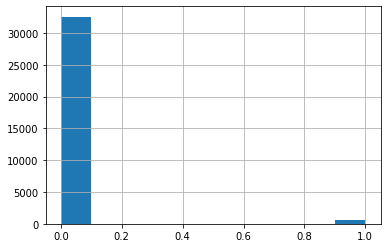

In [10]:
print(orig_train_df["target"].value_counts())
orig_train_df["target"].hist()

In [12]:
orig_test_df = pd.read_csv(GCS_PATH_ORIG_TEST_CSV)
orig_test_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


Above the tabular features we have.  

Actual images in tfrecord format (also available in jpeg)

In [6]:
print(tf.io.gfile.listdir(GCS_PATH_ORIG_TFR))

['test00-687.tfrec', 'test01-687.tfrec', 'test02-687.tfrec', 'test03-687.tfrec', 'test04-687.tfrec', 'test05-687.tfrec', 'test06-687.tfrec', 'test07-687.tfrec', 'test08-687.tfrec', 'test09-687.tfrec', 'test10-687.tfrec', 'test11-687.tfrec', 'test12-687.tfrec', 'test13-687.tfrec', 'test14-687.tfrec', 'test15-677.tfrec', 'train00-2071.tfrec', 'train01-2071.tfrec', 'train02-2071.tfrec', 'train03-2071.tfrec', 'train04-2071.tfrec', 'train05-2071.tfrec', 'train06-2071.tfrec', 'train07-2071.tfrec', 'train08-2071.tfrec', 'train09-2071.tfrec', 'train10-2071.tfrec', 'train11-2071.tfrec', 'train12-2071.tfrec', 'train13-2071.tfrec', 'train14-2071.tfrec', 'train15-2061.tfrec']


###  External Data - ISIC 2019

In [7]:
ext_train_df = pd.read_csv(GCS_PATH_EXT_TRAIN_CSV)
ext_train_df.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Only image names is important to us.  
The other columns are skin lesion class. our target variable is MEL - that is Melanoma.
Other features are available in.

In [8]:
ext_meta_df = pd.read_csv(GCS_PATH_EXT_TRAIN_META)
ext_meta_df.head()

,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male


#### Features

Features available both the dataset.  

* ```image_name```
* ```age_approx```
* ```anatom_site```
* ```sex```
* ```patient_id``` / ```lesion_id```

Feature in original but not in external

* ```diagnosis```

#### Label

* Original data - ```target``` column
* External data - ```MEL``` 
* Can the other target columns in Ext data be used as the ```diagnosis``` feature?

### The Diagnosis Feature

* In the original dataset we have a column ```diagnosis```
* In the ext dataset, our labels are actually diagnosis classes.
* But the nomenclature is a bit different.

#### Original

In [13]:
orig_train_df["diagnosis"].value_counts()

unknown                               27124
nevus                                  5193
melanoma                                584
seborrheic keratosis                    135
lentigo NOS                              44
lichenoid keratosis                      37
solar lentigo                             7
cafe-au-lait macule                       1
atypical melanocytic proliferation        1
Name: diagnosis, dtype: int64

#### External

In [14]:
ext_train_df.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* Looking at this article. : https://challenge2019.isic-archive.com/
* we can merge both the datasets` diagnosis feature.
  * Melanoma - Present in both, as MEL in EXT
  * Nevus - Present in both, as NV in EXT.
  * seborrheic keratosis, solar lentigo, lichenoid keratosis - as BKL in EXT
  * Lentigo NOS in ORIG - not in EXT
  * cafe-au-lait macule in ORIG - not in EXT
  * atypical melanocytic proliferation in ORIG - not in EXT
  * BCC in EXT - not in ORIG
  * AK in EXT - not in ORIG
  * DF in EXT - not in ORIG
  * VASC in EXT - not in ORIG
  * SCC in EXT - not in ORIG

### Combine both ORIG and EXT dataframe

In [33]:
# https://www.kaggle.com/shonenkov/merge-external-data

# convert diagsnois str to a key that matches external dataset.
diagnosis_key = {
    "melanoma"            : "MEL",
    "nevus"               : "NV",
    "seborrheic keratosis": "BKL",
    "lichenoid keratosis" : "BKL",
    "solar lentigo"       : "BKL",
    "lentigo NOS"         : "LNOS",
    "cafe-au-lait macule" : "CALM",
    "atypical melanocytic proliferation": "AMP",
    "unknown"             : "UNK",
}

dataset = {
    'patient_id' : [],
    'image_id': [],
    'source': [],
    'sex': [],
    'age_approx': [],
    'anatom_site_general_challenge': [],
    'diagnosis': [],
    'target': [],
}

# isic2020
df_train = pd.read_csv(GCS_PATH_ORIG_TRAIN_CSV, index_col='image_name')
for image_id, row in tqdm(df_train.iterrows(), total=df_train.shape[0]):
    if image_id in dataset['image_id']:
        continue
    dataset['patient_id'].append(row['patient_id'])
    dataset['image_id'].append(image_id)
    dataset['target'].append(row['target'])
    dataset['source'].append('ISIC20')
    dataset['sex'].append(row['sex'])
    dataset['age_approx'].append(row['age_approx'])
    dataset['anatom_site_general_challenge'].append(row['anatom_site_general_challenge'])
    dataset['diagnosis'].append(diagnosis_key[row['diagnosis']])

# isic2019
df_gt = pd.read_csv(GCS_PATH_EXT_TRAIN_CSV, index_col='image')
df_meta = pd.read_csv(GCS_PATH_EXT_TRAIN_META, index_col='image')
for image_id, row in tqdm(df_meta.iterrows(), total=df_meta.shape[0]):
    if image_id in dataset['image_id'] or "downsampled" in image_id.lower(): # duplicate images in external as per: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/155859#878163
        continue

    dataset['patient_id'].append(row['lesion_id'])
    dataset['image_id'].append(image_id)
    dataset['target'].append(int(df_gt.loc[image_id]['MEL']))
    dataset['source'].append('ISIC19')
    dataset['sex'].append(row['sex'])
    dataset['age_approx'].append(row['age_approx'])
    dataset['anatom_site_general_challenge'].append(
        {'anterior torso': 'torso', 'posterior torso': 'torso'}.get(row['anatom_site_general'], row['anatom_site_general'])
    )
    # diagnosis
    bool_mask = df_gt.loc[image_id].eq(1) # gives True for the column where 1 and False for others
    diagnosis = bool_mask.index[bool_mask][0]
    dataset['diagnosis'].append(diagnosis)

100%|██████████| 25331/25331 [00:36<00:00, 694.20it/s]


In [34]:
combined_df = pd.DataFrame(dataset)
combined_df.head()

,patient_id,image_id,source,sex,age_approx,anatom_site_general_challenge,diagnosis,target
0,IP_7279968,ISIC_2637011,ISIC20,male,45.0,head/neck,UNK,0
1,IP_3075186,ISIC_0015719,ISIC20,female,45.0,upper extremity,UNK,0
2,IP_2842074,ISIC_0052212,ISIC20,female,50.0,lower extremity,NV,0
3,IP_6890425,ISIC_0068279,ISIC20,female,45.0,head/neck,UNK,0
4,IP_8723313,ISIC_0074268,ISIC20,female,55.0,upper extremity,UNK,0


### Some Histogram Check

#### Data Source

ISIC20    33126
ISIC19    23257
Name: source, dtype: int64


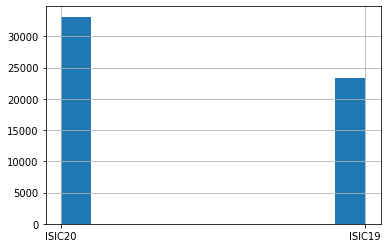

In [35]:
print(combined_df['source'].value_counts())
combined_df['source'].hist()

#### Target distribution

0    51651
1     4732
Name: target, dtype: int64


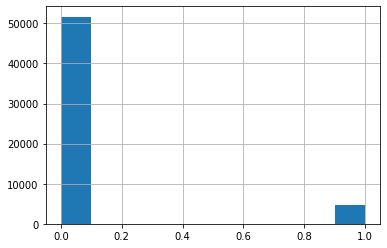

In [36]:
print(combined_df["target"].value_counts())
combined_df["target"].hist()

#### Gender distribution

male      29359
female    26755
Name: sex, dtype: int64


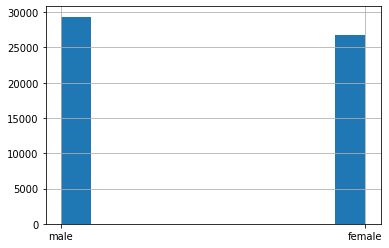

In [37]:
print(combined_df["sex"].value_counts())
combined_df["sex"].hist()

#### Lesion Location Distribution

torso              25994
lower extremity    13151
upper extremity     7632
head/neck           6241
palms/soles          766
oral/genital         183
lateral torso          6
Name: anatom_site_general_challenge, dtype: int64


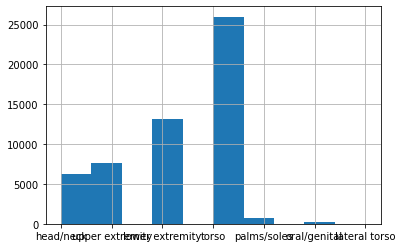

In [38]:
print(combined_df["anatom_site_general_challenge"].value_counts())
combined_df["anatom_site_general_challenge"].hist()

#### Age Distribution

45.0    6880
50.0    6606
55.0    5857
40.0    5695
60.0    5101
65.0    4441
35.0    4403
70.0    3921
30.0    3468
75.0    2658
25.0    2144
80.0    1789
85.0    1398
20.0    1023
15.0     326
10.0     136
5.0      110
90.0      80
0.0       56
Name: age_approx, dtype: int64


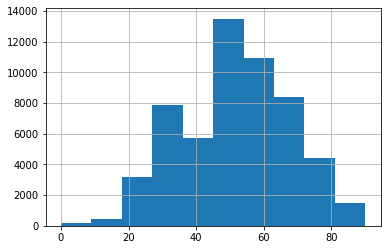

In [41]:
print(combined_df["age_approx"].value_counts())
combined_df["age_approx"].hist()

#### Diagnosis Distribution

UNK     27124
NV      16752
MEL      4732
BCC      3323
BKL      2419
AK        867
SCC       628
VASC      253
DF        239
LNOS       44
CALM        1
AMP         1
Name: diagnosis, dtype: int64


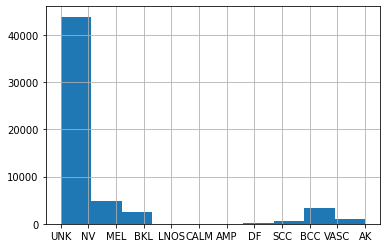

In [40]:
print(combined_df["diagnosis"].value_counts())
combined_df["diagnosis"].hist()

#### # of images per patient

In [42]:
print(combined_df["patient_id"].value_counts())

IP_7279968     115
IP_4938382     115
IP_4382720     115
IP_4479736     115
IP_0656529     114
              ... 
HAM_0004160      1
HAM_0002778      1
HAM_0003141      1
HAM_0004136      1
HAM_0003935      1
Name: patient_id, Length: 13105, dtype: int64


### Creating TFRecords - Image + Context

We may have to consider the cross validation policies while creating TFRecords

In [0]:
# https://www.tensorflow.org/tutorials/load_data/tfrecord

# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [0]:
def serialize_example(patient_id, image_id, image, source, sex, age_approx, anatom_site_general_challenge, diagnosis, target):
  feature = {
      'patient_id': _bytes_feature(patient_id),
      'image_id': _bytes_feature(image_id),
      'image': _bytes_feature(image),
      'source': _bytes_feature(source),
      'sex': _bytes_feature(sex),
      'age_approx': _int64_feature(age_approx),
      'anatom_site_general_challenge': _bytes_feature(anatom_site_general_challenge),
      'diagnosis': _bytes_feature(diagnosis),
      'target': _int64_feature(target)
  }
  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()